# <html>

   

<div style="background-image: linear-gradient(to left, rgb(255, 255, 255), rgb(138, 136, 136)); width: auto; margin: 10px;">

  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/University_of_Tehran_logo.svg/225px-University_of_Tehran_logo.svg.png" width=100px width=auto style="padding:10px; vertical-align: center;">



</div>

   

<div   style:"text-align: center; background-image: linear-gradient(to left, rgb(255, 255, 255), rgb( 219, 204, 245  ));width: 400px; height: 30px; ">

<h1 style="font-family: Georgia; color: black; text-align: center; ">Course: NNDL </h1>



</div>

<div   style:"border: 3px solid green;text-align: center; ">

<h1 style="font-family: Georgia; color: black; text-align: center; ">Project5 - Question2 </h1>



</div>



   <div>    

<h1 style="font-family: Georgia; color: black; text-align: center; font-size:15px;">Mohammad Amanlou- sid:810100084 </h1>





</div>

   



</html>

#Essential libraries

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
from torchvision import models, datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split

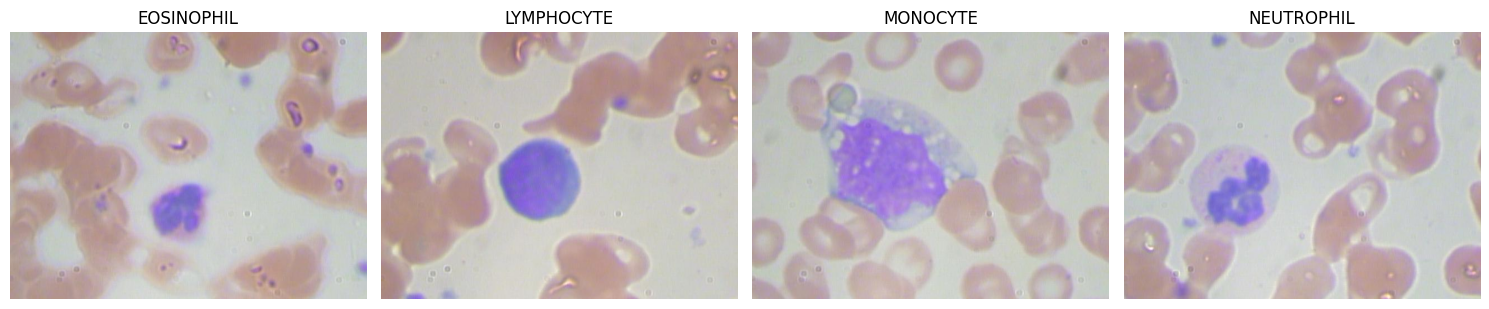

In [2]:
zip_file_path = "/content/Q2_Data.zip"
extracted_path = "/content/Q2_Data"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)


classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, cls in enumerate(classes):
    class_folder = os.path.join(extracted_path, cls)
    sample_image_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    img = Image.open(sample_image_path)

    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [3]:
dataset_path = "/content/Q2_Data"

# List of classes
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

image_counts = {}
for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    image_counts[cls] = len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))])

for cls, count in image_counts.items():
    print(f"{cls}: {count} images")


EOSINOPHIL: 88 images
LYMPHOCYTE: 33 images
MONOCYTE: 20 images
NEUTROPHIL: 206 images


#Data augmentation and preprocessing

In [4]:
# Define paths and parameters
dataset_path = "/content/Q2_Data"
processed_data_path = "Q2_Data_Preprocessed"
augment_classes = ['LYMPHOCYTE', 'MONOCYTE']
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
target_count = 100

# Create directories for preprocessed data
os.makedirs(processed_data_path, exist_ok=True)
for cls in classes:
    os.makedirs(os.path.join(processed_data_path, cls), exist_ok=True)

# Define augmentation transformations
augmentations = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Resize for ViT
])

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Process images in each class
for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    processed_class_folder = os.path.join(processed_data_path, cls)
    images = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]

    # Augment images if the class is in augment_classes
    while cls in augment_classes and len(images) < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path).convert("RGB")

        # Apply augmentations
        augmented_img = augmentations(img)
        save_name = f"aug_{len(images)}.png"
        augmented_img.save(os.path.join(class_folder, save_name))
        images.append(save_name)

    # Preprocess all images
    for img_name in images:
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format

        # Apply preprocessing
        img_tensor = preprocess(img)

        # Save preprocessed image
        save_path = os.path.join(processed_class_folder, img_name)
        transforms.ToPILImage()(img_tensor).save(save_path)

    print(f"Class {cls} processed with {len(images)} images.")

print("Data augmentation and preprocessing complete. Preprocessed images saved in 'Q2_Data_Preprocessed'.")


Class EOSINOPHIL processed with 88 images.
Class LYMPHOCYTE processed with 100 images.
Class MONOCYTE processed with 100 images.
Class NEUTROPHIL processed with 206 images.
Data augmentation and preprocessing complete. Preprocessed images saved in 'Q2_Data_Preprocessed'.


# Split data

In [5]:
# Define paths
dataset_path = "Q2_Data_Preprocessed"  # Preprocessed data path
output_path = "Q2_Split_Data"  # Path for split data

# Create directories for train and validation sets
train_path = os.path.join(output_path, "train")
val_path = os.path.join(output_path, "val")

# Ensure folders exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Classes
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Split data for each class
for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]

    # Split data into train and validation sets
    train_images, val_images = train_test_split(images, test_size=0.1, random_state=42)

    # Create class folders in train and validation directories
    os.makedirs(os.path.join(train_path, cls), exist_ok=True)
    os.makedirs(os.path.join(val_path, cls), exist_ok=True)

    # Move images to respective folders
    for img_name in train_images:
        shutil.copy(os.path.join(class_folder, img_name), os.path.join(train_path, cls, img_name))
    for img_name in val_images:
        shutil.copy(os.path.join(class_folder, img_name), os.path.join(val_path, cls, img_name))

    print(f"Class {cls}: {len(train_images)} training and {len(val_images)} validation images.")

print("Dataset splitting complete. Data saved in 'Q2_Split_Data'.")


Class EOSINOPHIL: 79 training and 9 validation images.
Class LYMPHOCYTE: 90 training and 10 validation images.
Class MONOCYTE: 90 training and 10 validation images.
Class NEUTROPHIL: 185 training and 21 validation images.
Dataset splitting complete. Data saved in 'Q2_Split_Data'.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained ViT model from torchvision
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)  # Pre-trained on ImageNet-1K

# Modify the output layer for 4 classes
num_classes = 4
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, num_classes)
)

# Move the model to GPU (if available)
model = model.to(device)

# Display the model architecture
print(model)


Using device: cuda
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=Tr

# Model 1


Using device: cuda
Total Parameters: 85801732
Trainable Parameters: 3076
Epoch 1/10 - Loss: 1.1898, Accuracy: 0.4707
Epoch 2/10 - Loss: 0.9212, Accuracy: 0.6329
Epoch 3/10 - Loss: 0.8057, Accuracy: 0.6869
Epoch 4/10 - Loss: 0.7344, Accuracy: 0.7072
Epoch 5/10 - Loss: 0.6754, Accuracy: 0.7545
Epoch 6/10 - Loss: 0.6457, Accuracy: 0.7568
Epoch 7/10 - Loss: 0.6078, Accuracy: 0.7748
Epoch 8/10 - Loss: 0.5771, Accuracy: 0.7883
Epoch 9/10 - Loss: 0.5463, Accuracy: 0.8176
Epoch 10/10 - Loss: 0.5144, Accuracy: 0.8131
Training complete!


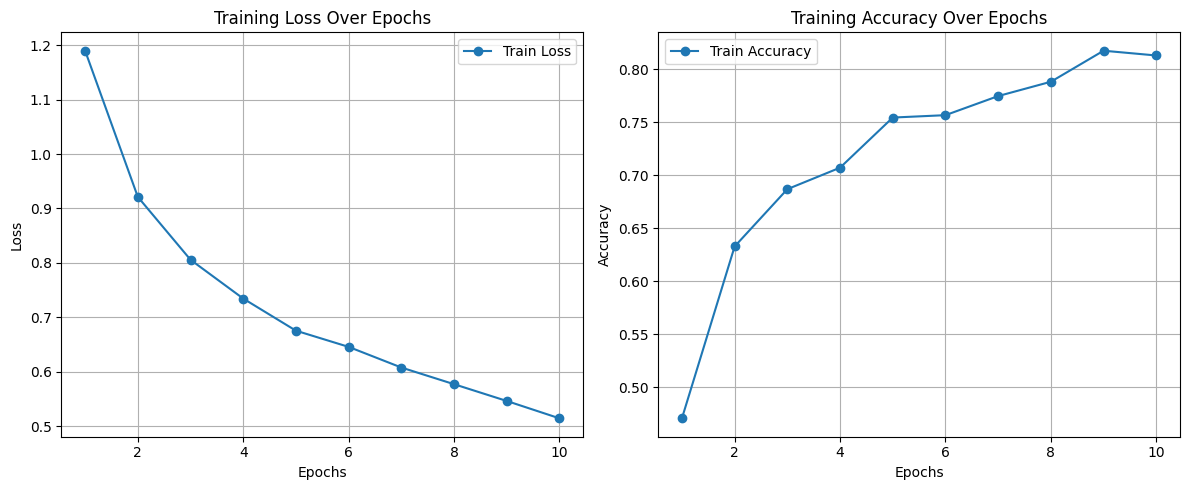

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load the Pre-trained ViT Model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
num_classes = 4

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify classifier (output layer)
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, num_classes)
)

# Ensure classifier parameters are trainable
for param in model.heads.parameters():
    param.requires_grad = True

# Move model to device
model = model.to(device)

# 2. Display Model Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

# 3. Load Dataset (Preprocessed Split Data)
data_dir = "Q2_Split_Data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.parameters(), lr=0.001)


num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("Training complete!")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', linestyle='-', label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Accuracy: 0.8000

Precision, Recall, F1-Score:
EOSINOPHIL: Precision: 0.4444, Recall: 0.4444, F1-Score: 0.4444
LYMPHOCYTE: Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
MONOCYTE: Precision: 0.8889, Recall: 0.8000, F1-Score: 0.8421
NEUTROPHIL: Precision: 0.8182, Recall: 0.8571, F1-Score: 0.8372


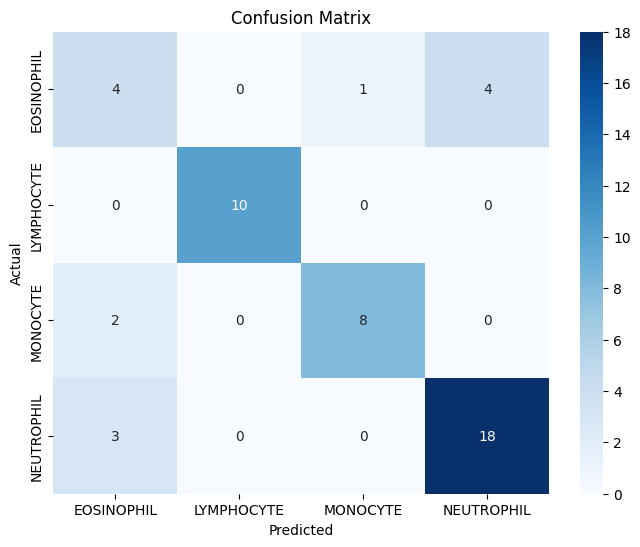

In [ ]:
model.eval()


val_dir = "Q2_Split_Data/val"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load validation data
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class names
class_names = val_dataset.classes

# Initialize predictions and labels
all_preds = []
all_labels = []

# Evaluate on validation data
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision, Recall, and F1-Score for Each Class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=range(len(class_names)))

print("\nPrecision, Recall, F1-Score:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# 3. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Model 2

Using device: cuda
Total Parameters: 85801732
Trainable Parameters: 14178820
Epoch 1/10 - Loss: 1.2697, Accuracy: 0.4527
Epoch 2/10 - Loss: 0.9862, Accuracy: 0.6194
Epoch 3/10 - Loss: 0.7729, Accuracy: 0.7140
Epoch 4/10 - Loss: 0.5982, Accuracy: 0.8536
Epoch 5/10 - Loss: 0.4574, Accuracy: 0.9189
Epoch 6/10 - Loss: 0.3298, Accuracy: 0.9550
Epoch 7/10 - Loss: 0.2265, Accuracy: 0.9820
Epoch 8/10 - Loss: 0.1604, Accuracy: 0.9955
Epoch 9/10 - Loss: 0.1118, Accuracy: 0.9955
Epoch 10/10 - Loss: 0.0794, Accuracy: 0.9955
Training complete!
Model saved as 'ViT_Mode2_Finetuned.pth'.


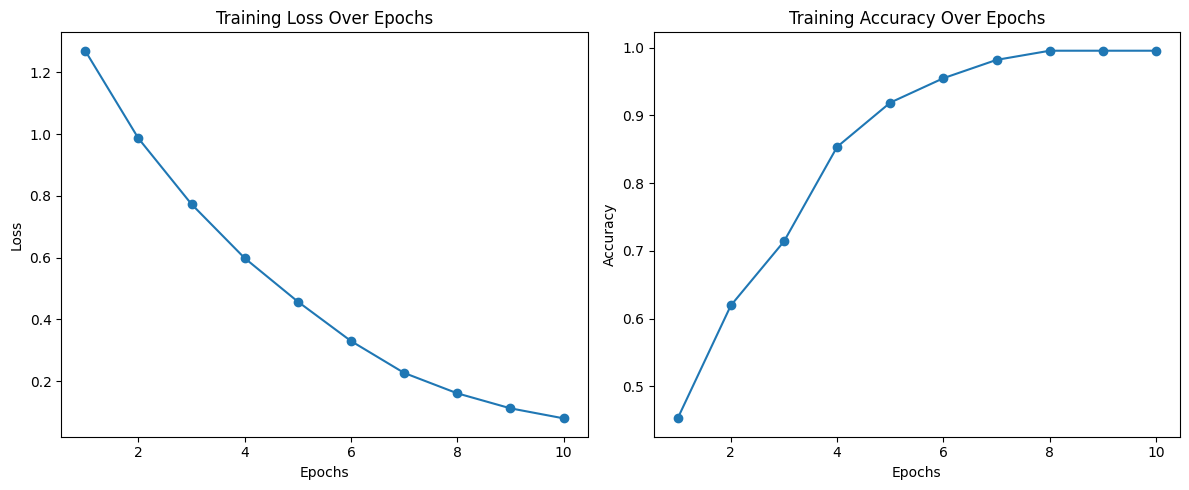

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load Pre-trained ViT Model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
num_classes = 4  # Number of output classes

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the first two encoder layers
for i in range(2):  # Unfreeze the first two encoder layers
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

model.heads = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.heads.head.in_features, num_classes)
)

for param in model.heads.parameters():
    param.requires_grad = True

model = model.to(device)

# 3. Display Model Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

# 4. Load Dataset
data_dir = "Q2_Split_Data"  # Preprocessed and split dataset
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"

# Define transformations (Data is already preprocessed)
transform = transforms.Compose([
    transforms.ToTensor(),

])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 5. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.0001)

# 6. Training Loop with Plots
num_epochs = 10
train_losses = []  # Store training losses
train_accuracies = []  # Store training accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("Training complete!")

# Save the model
torch.save(model.state_dict(), "ViT_Mode2_Finetuned.pth")
print("Model saved as 'ViT_Mode2_Finetuned.pth'.")

# 7. Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', linestyle='-')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


<ipython-input-10-9bba4ff8261a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ViT_Mode2_Finetuned.pth"))


Validation Accuracy: 0.7600

Precision, Recall, F1-Score:
EOSINOPHIL: Precision: 0.7500, Recall: 0.3333, F1-Score: 0.4615
LYMPHOCYTE: Precision: 0.8750, Recall: 0.7000, F1-Score: 0.7778
MONOCYTE: Precision: 0.6923, Recall: 0.9000, F1-Score: 0.7826
NEUTROPHIL: Precision: 0.7600, Recall: 0.9048, F1-Score: 0.8261


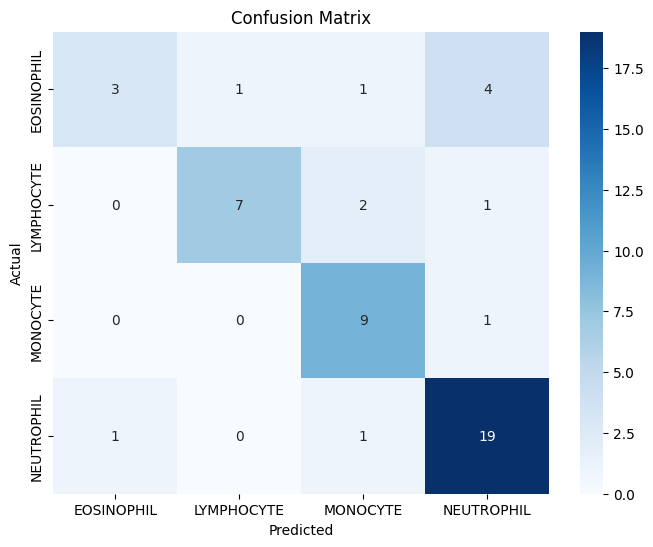

In [ ]:

model.load_state_dict(torch.load("ViT_Mode2_Finetuned.pth"))
model = model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# 4. Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
class_names = val_dataset.classes

print("\nPrecision, Recall, F1-Score:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# 5. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Model 3

Using device: cuda
Total Parameters: 85801732
Trainable Parameters: 14178820
Epoch 1/10 - Loss: 1.1248, Accuracy: 0.5405
Epoch 2/10 - Loss: 0.7245, Accuracy: 0.7140
Epoch 3/10 - Loss: 0.5255, Accuracy: 0.7838
Epoch 4/10 - Loss: 0.3672, Accuracy: 0.8874
Epoch 5/10 - Loss: 0.2598, Accuracy: 0.9054
Epoch 6/10 - Loss: 0.2863, Accuracy: 0.8941
Epoch 7/10 - Loss: 0.1621, Accuracy: 0.9505
Epoch 8/10 - Loss: 0.0928, Accuracy: 0.9752
Epoch 9/10 - Loss: 0.0646, Accuracy: 0.9775
Epoch 10/10 - Loss: 0.0410, Accuracy: 0.9910
Training complete!


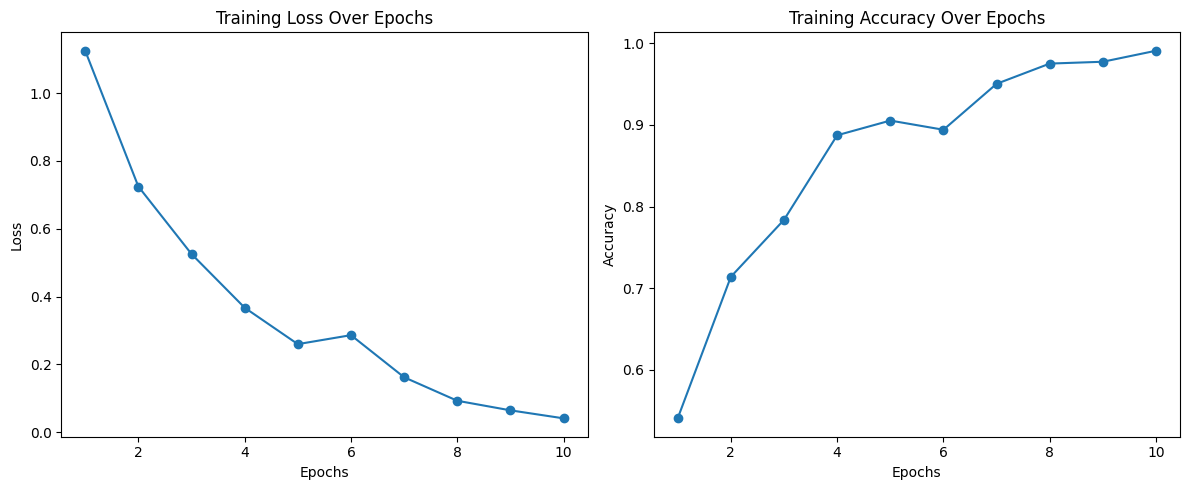

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
num_classes = 4

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two encoder layers
for i in range(10, 12):  # Unfreezing last 2 layers (Assuming 12 layers)
    for param in model.encoder.layers[i].parameters():
        param.requires_grad = True

# Modify classifier and unfreeze it
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, num_classes)
)
for param in model.heads.parameters():
    param.requires_grad = True

# Move model to device
model = model.to(device)

# 3. Display Model Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

# 4. Load Dataset (Preprocessed Data - No additional preprocessing)
data_dir = "Q2_Split_Data"  # Preprocessed data path
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"

# Use only ToTensor since data is preprocessed
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 5. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.0001)

# 6. Training Loop with Plotting
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    # Append metrics for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("Training complete!")

# 7. Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


Validation Accuracy: 0.8200

Precision, Recall, F1-Score:
EOSINOPHIL: Precision: 0.6667, Recall: 0.4444, F1-Score: 0.5333
LYMPHOCYTE: Precision: 1.0000, Recall: 0.9000, F1-Score: 0.9474
MONOCYTE: Precision: 0.8182, Recall: 0.9000, F1-Score: 0.8571
NEUTROPHIL: Precision: 0.7917, Recall: 0.9048, F1-Score: 0.8444


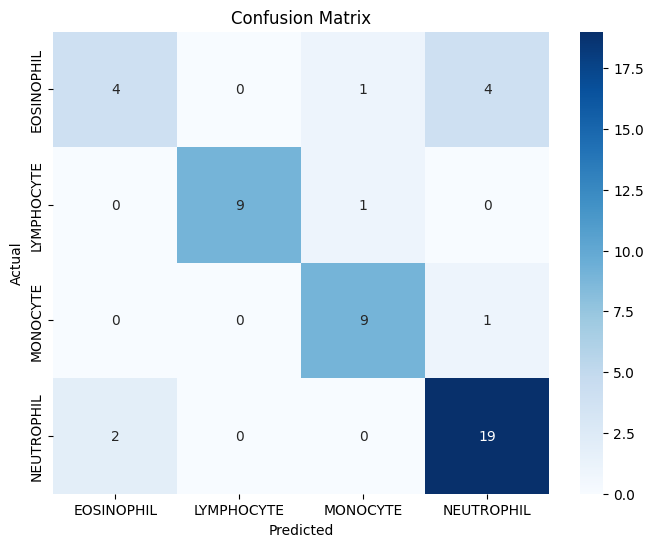

In [ ]:
# 1. Evaluation on Validation Data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# 3. Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
class_names = val_dataset.classes

print("\nPrecision, Recall, F1-Score:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# 4. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Model 4

Using device: cuda
Total Parameters: 85801732
Trainable Parameters: 85801732
Epoch 1/10 - Loss: 1.1555, Accuracy: 0.4955
Epoch 2/10 - Loss: 0.9648, Accuracy: 0.5698
Epoch 3/10 - Loss: 0.8269, Accuracy: 0.6396
Epoch 4/10 - Loss: 0.5649, Accuracy: 0.7680
Epoch 5/10 - Loss: 0.2871, Accuracy: 0.8986
Epoch 6/10 - Loss: 0.2693, Accuracy: 0.9032
Epoch 7/10 - Loss: 0.1305, Accuracy: 0.9617
Epoch 8/10 - Loss: 0.0475, Accuracy: 0.9842
Epoch 9/10 - Loss: 0.0108, Accuracy: 0.9977
Epoch 10/10 - Loss: 0.0029, Accuracy: 1.0000
Training complete!
Model saved as 'ViT_Full_Finetuned.pth'


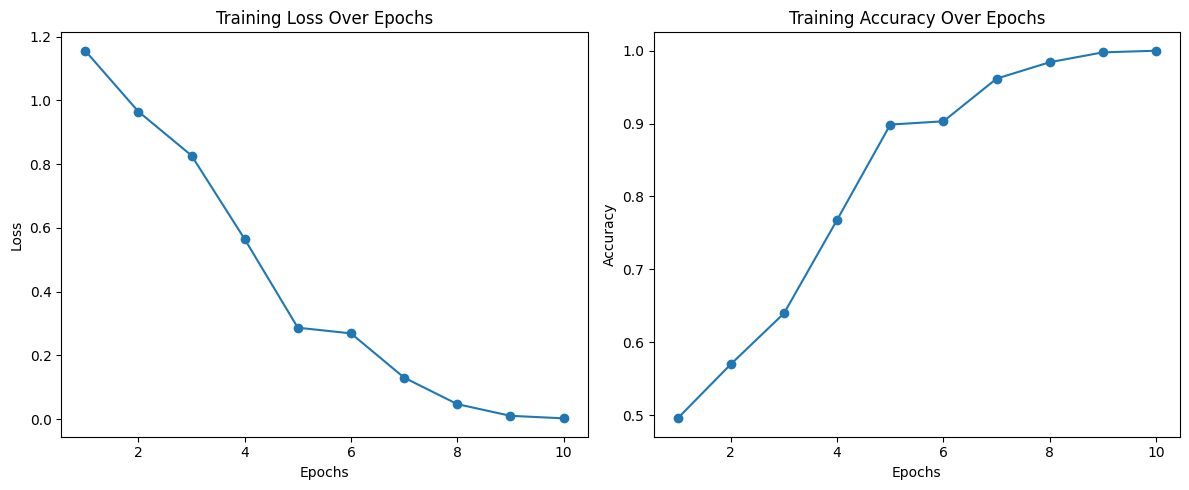

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
num_classes = 4

# Unfreeze all layers for full fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Modify classifier
model.heads = nn.Sequential(
    nn.Linear(model.heads.head.in_features, num_classes)
)

# Move model to device
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

data_dir = "Q2_Split_Data"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("Training complete!")


torch.save(model.state_dict(), "ViT_Full_Finetuned.pth")
print("Model saved as 'ViT_Full_Finetuned.pth'")

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


<ipython-input-12-773a7f59f2d8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ViT_Full_Finetuned.pth"))


Validation Accuracy: 0.9200

Precision, Recall, F1-Score:
EOSINOPHIL: Precision: 0.7778, Recall: 0.7778, F1-Score: 0.7778
LYMPHOCYTE: Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
MONOCYTE: Precision: 0.9091, Recall: 1.0000, F1-Score: 0.9524
NEUTROPHIL: Precision: 0.9500, Recall: 0.9048, F1-Score: 0.9268


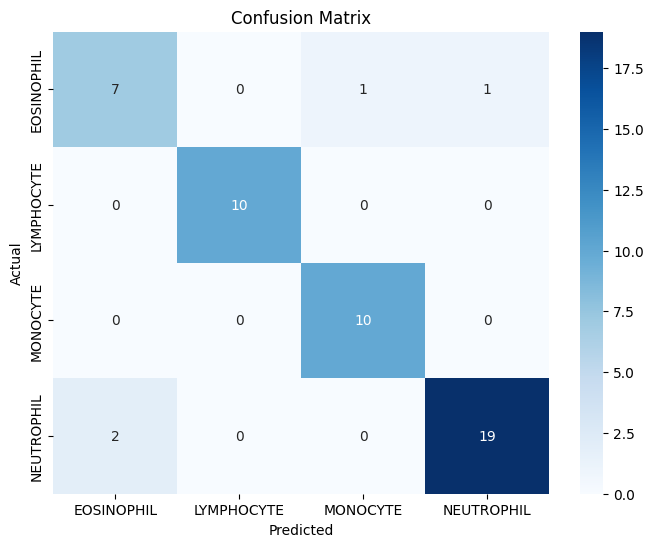

In [ ]:
# 1. Load the Trained Model
model.load_state_dict(torch.load("ViT_Full_Finetuned.pth"))
model = model.to(device)
model.eval()

# 2. Evaluate on Validation Data
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# 4. Precision, Recall, and F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
class_names = val_dataset.classes

print("\nPrecision, Recall, F1-Score:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# 5. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#CNN Model

Using device: cuda
Total Parameters: 6957956
Trainable Parameters: 6957956
Epoch 1/10 - Train Loss: 1.2833, Train Acc: 0.3964
Epoch 2/10 - Train Loss: 0.8569, Train Acc: 0.6734
Epoch 3/10 - Train Loss: 0.6303, Train Acc: 0.7725
Epoch 4/10 - Train Loss: 0.4717, Train Acc: 0.8716
Epoch 5/10 - Train Loss: 0.3692, Train Acc: 0.8986
Epoch 6/10 - Train Loss: 0.2480, Train Acc: 0.9459
Epoch 7/10 - Train Loss: 0.1827, Train Acc: 0.9572
Epoch 8/10 - Train Loss: 0.1561, Train Acc: 0.9685
Epoch 9/10 - Train Loss: 0.1014, Train Acc: 0.9865
Epoch 10/10 - Train Loss: 0.0864, Train Acc: 0.9775
Training complete!
Model saved as 'DenseNet121_Final_Finetuned.pth'


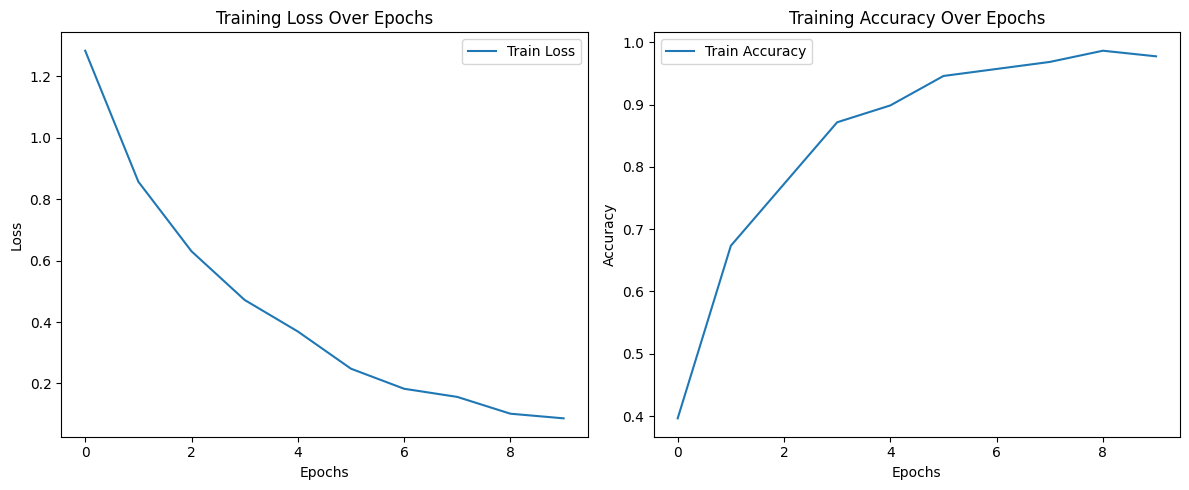

In [14]:
# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load Pre-trained DenseNet-121 Model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_classes = 4  # Number of output classes

# Unfreeze all layers for full fine-tuning
for param in model.parameters():
    param.requires_grad = True  # Make all parameters trainable

# Modify the classifier with Dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Dropout to prevent overfitting
    nn.Linear(model.classifier.in_features, num_classes)
)

# Move model to device
model = model.to(device)

# 3. Display Model Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

# 4. Load Dataset with Augmentation
data_dir = "Q2_Split_Data"
train_dir = f"{data_dir}/train"

# Apply transformations including Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Horizontal Flip
    transforms.RandomRotation(10),  # Rotation up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness and contrast adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 5. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 6. Training Loop without Early Stopping
num_epochs = 10
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute metrics for this epoch
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

print("Training complete!")

# Save the final model
torch.save(model.state_dict(), "DenseNet121_Final_Finetuned.pth")
print("Model saved as 'DenseNet121_Final_Finetuned.pth'")

# 7. Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Using device: cuda


<ipython-input-15-0ac7bead23b0>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("DenseNet121_Full_Finetuned_TrainOnly.pth"))


Accuracy: 0.8200

Precision, Recall, F1-Score:
EOSINOPHIL: Precision: 0.6250, Recall: 0.5556, F1-Score: 0.5882
LYMPHOCYTE: Precision: 0.9091, Recall: 1.0000, F1-Score: 0.9524
MONOCYTE: Precision: 1.0000, Recall: 0.8000, F1-Score: 0.8889
NEUTROPHIL: Precision: 0.7826, Recall: 0.8571, F1-Score: 0.8182


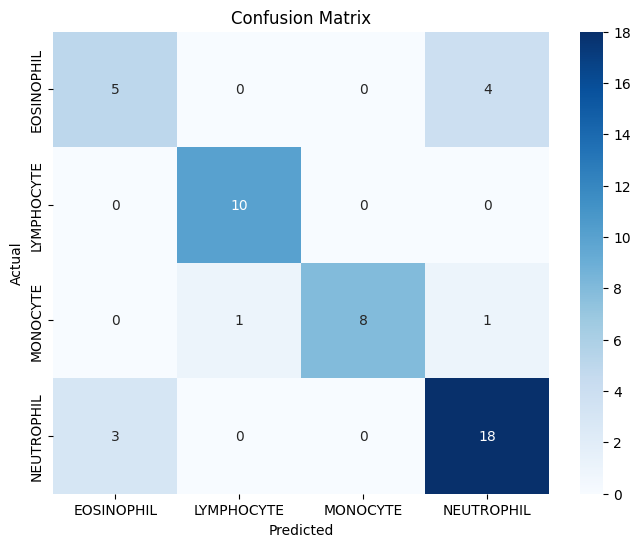

In [15]:
# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load Pre-trained DenseNet-121 Model (Saved Model)
from torchvision import models

num_classes = 4  # Number of output classes

# Load the same model architecture used in training
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, num_classes)
)

# Load the trained weights
model.load_state_dict(torch.load("DenseNet121_Full_Finetuned_TrainOnly.pth"))
model = model.to(device)
model.eval()  # Set to evaluation mode

# 3. Load Validation Dataset (Preprocessed)
data_dir = "Q2_Split_Data"
val_dir = f"{data_dir}/val"

# Define transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load validation dataset
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Initialize Metrics
class_names = val_dataset.classes
all_preds = []
all_labels = []

# 5. Evaluate Model
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 6. Calculate Metrics
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
print("\nPrecision, Recall, F1-Score:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# 7. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Bonus section

Using device: cuda
Total Parameters: 6957956
Trainable Parameters: 4100
Epoch 1/20 - Train Loss: 1.2482, Train Acc: 0.4640
Epoch 2/20 - Train Loss: 1.0250, Train Acc: 0.5743
Epoch 3/20 - Train Loss: 0.9250, Train Acc: 0.6261
Epoch 4/20 - Train Loss: 0.8768, Train Acc: 0.6374
Epoch 5/20 - Train Loss: 0.8330, Train Acc: 0.6937
Epoch 6/20 - Train Loss: 0.7817, Train Acc: 0.7297
Epoch 7/20 - Train Loss: 0.7422, Train Acc: 0.7005
Epoch 8/20 - Train Loss: 0.7376, Train Acc: 0.7432
Epoch 9/20 - Train Loss: 0.6928, Train Acc: 0.7455
Epoch 10/20 - Train Loss: 0.6463, Train Acc: 0.7725
Epoch 11/20 - Train Loss: 0.6393, Train Acc: 0.7793
Epoch 12/20 - Train Loss: 0.6052, Train Acc: 0.7905
Epoch 13/20 - Train Loss: 0.5930, Train Acc: 0.8131
Epoch 14/20 - Train Loss: 0.5817, Train Acc: 0.8131
Epoch 15/20 - Train Loss: 0.5570, Train Acc: 0.8423
Epoch 16/20 - Train Loss: 0.5432, Train Acc: 0.7995
Epoch 17/20 - Train Loss: 0.5008, Train Acc: 0.8604
Epoch 18/20 - Train Loss: 0.5377, Train Acc: 0.8176
E

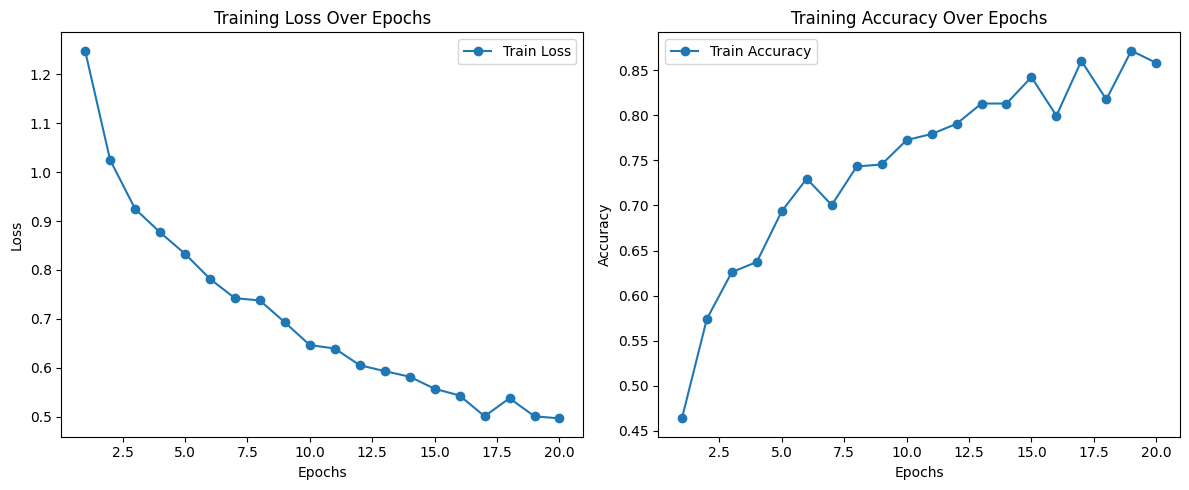

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load Pre-trained DenseNet-121 Model
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_classes = 4  # Number of output classes

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier for multi-class classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, num_classes)  # Output 4 classes
)

# Ensure classifier parameters are trainable
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to device
model = model.to(device)

# 3. Display Model Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

# 4. Load Dataset (Preprocessed)
data_dir = "Q2_Split_Data"  # Preprocessed data path
train_dir = f"{data_dir}/train"

# Define transformations (Preprocessed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for DenseNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 5. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# 6. Training Loop
num_epochs = 20
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

print("Training complete!")

# Save the model
torch.save(model.state_dict(), "DenseNet121_Classifier_TrainOnly.pth")
print("Model saved as 'DenseNet121_Classifier_TrainOnly.pth'")

# 7. Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', linestyle='-', label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Using device: cuda


<ipython-input-17-e6ca7c5435ef>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("DenseNet121_Classifier_TrainOnly.pth"))


Accuracy: 0.7400

Precision, Recall, F1-Score:
EOSINOPHIL: Precision: 0.6667, Recall: 0.4444, F1-Score: 0.5333
LYMPHOCYTE: Precision: 0.7500, Recall: 0.6000, F1-Score: 0.6667
MONOCYTE: Precision: 0.8889, Recall: 0.8000, F1-Score: 0.8421
NEUTROPHIL: Precision: 0.7037, Recall: 0.9048, F1-Score: 0.7917


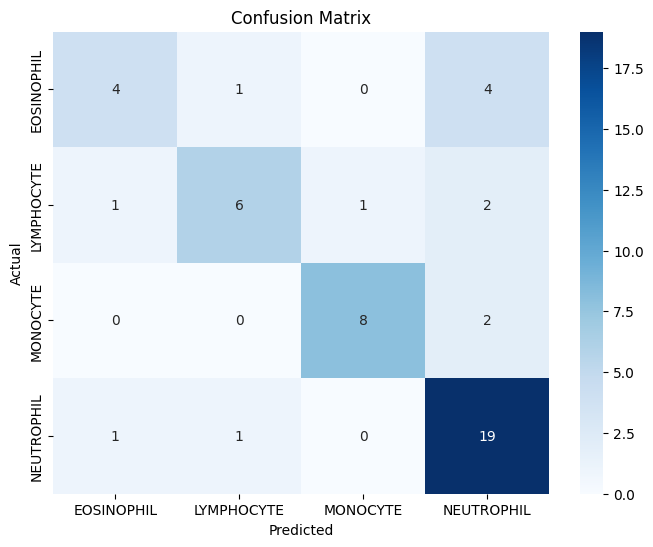

In [17]:
# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load the trained model
model = models.densenet121()
num_classes = 4

# Modify the classifier to match the number of classes
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, num_classes)
)

# Load saved weights
model.load_state_dict(torch.load("DenseNet121_Classifier_TrainOnly.pth"))
model = model.to(device)
model.eval()

# 3. Load Validation Dataset
data_dir = "Q2_Split_Data"
val_dir = f"{data_dir}/val"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. Initialize metrics
all_preds = []
all_labels = []

# Evaluate the model
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. Calculate Metrics
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
class_names = val_dataset.classes

print("\nPrecision, Recall, F1-Score:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# 6. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
